# Scraping CoinMarketCap to produce a crypto portfolio valuation

## Section 1. Overview and project scope

[Coinmarketcap](https://coinmarketcap.com/) is a website that provides real-time data on [cryptocurrencies](https://en.wikipedia.org/wiki/Cryptocurrency). The scope of this project is to leverage Python to:

1. retrieve real-time crypto currency prices from [Coinmarketcap](https://coinmarketcap.com)
2. retrieve real-time foreign exchange rates from [Google Finance](https://www.google.com/finance/)
3. add struture to the retrieved data by creating custom Classes  
4. allow the user to select a portfolio of cryptocurrencies and holdings
5. provide a real-time portfolio valuation based on the user selelction

## Section 2. Import the required libraries

In [1]:
import requests as r
import re
from bs4 import BeautifulSoup
from dataclasses import dataclass
from typing import List
import datetime as dt

In [2]:
now = dt.datetime.now()
print(now)

2025-01-17 15:32:26.737067


## Section 3. Retrieving real time data 

A modern dynamic web page generally comprises of a combination of [HTML (Hypertext Markup Lanaguage)](https://en.wikipedia.org/wiki/HTML), [CSS (Cascading Style Sheets)](https://en.wikipedia.org/wiki/CSS) and [JS (JavaScript)](https://simple.wikipedia.org/wiki/JavaScript). We can navigate this complex structure by leveraging the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [Requests](https://requests.readthedocs.io/en/latest/) Python libraries.

Let's illustrate how we can obtain real-time forex rates from Google Finance in just a few lines of code.

### Section 3.1 Forex rates

In [3]:
# Custom function to parse exchange rate
def exchange_from_dollar(target_currency):
    
    fx_url = f"https://www.google.com/finance/quote/USD-{target_currency}"
    resp = r.get(fx_url)
    soup = BeautifulSoup(resp.content, "html.parser")
    fx_rate = soup.find("div", attrs={"data-last-price": True})
    fx = float(fx_rate["data-last-price"])
    
    return fx

exchange_from_dollar("GBP") #specify currency to convert from USD

0.820915

### Section 3.2 Crypto prices

We can obtain real-time cryto prices from Coinmarketcap in a similar way.

In [4]:
# Parse the crypto price data
def get_price_info(coin_symbol, target_currency):
    
    fx = exchange_from_dollar(target_currency)
    url = f"https://coinmarketcap.com/currencies/{coin_symbol}/"
    resp = r.get(url)
    soup = BeautifulSoup(resp.content, "html.parser")

    # Locate the span using the `data-test` attribute
    price_span = soup.find("span", {"data-test": "text-cdp-price-display"})
    price_dollars = price_span.text.strip()
    usd_price = float(re.sub("[^0-9.]", "", price_dollars))
    target_currency_price = round(usd_price * fx, 3)

    return {
        "coin_symbol": coin_symbol,
        "usd_price": usd_price,
        "target_currency": target_currency,
        "target_currency_price": target_currency_price        
    }


btc_price_gbp = get_price_info("bitcoin", "GBP")
print(
    f"The value of one unit of {btc_price_gbp['coin_symbol']} on {now:%A}, {now:%d-%m-%Y} in {btc_price_gbp['target_currency']} "
    f"is {btc_price_gbp['target_currency_price']:,.2f}."
)

The value of one unit of bitcoin on Friday, 17-01-2025 in GBP is 84,278.44.


Nearly £85k. Now, where is that old laptop ... !

OK, so this seems to be working well, but is somewhat limited at the moment. Let's scale things up to allow for a portfolio of currencies and holdings, amd add some structure to our data.

### Section 4. Adding Structure with Dataclasses

It would be helpful if we could structure and store our data relating to particular stocks and holdings in a container for easy access. We can leverage the Python [Dataclasses module](https://docs.python.org/3/library/dataclasses.html) to achieve this.  Let's illustrate by creating a custom `Coin` Class.

In [5]:
from dataclasses import dataclass

@dataclass
class Coin:
    coin_symbol: str
    #price: float = 0  # default values
    target_currency: str = "GBP"  # default values
    usd_price: float = 0  # default values
    target_currency_price: float = 0

    # After initiation, prices from Google kick in
    def __post_init__(self):  # self points to the object of type Coin
        price_info = get_price_info(self.coin_symbol, self.target_currency)

        # Only if logic is true, otherwise proceed with default values
        if price_info["coin_symbol"] == self.coin_symbol:
            self.usd_price = price_info["usd_price"]
            self.target_currency_price = price_info["target_currency_price"]

Given that our aim is ultimately to value a portfolio of crypto coin holdings, next we will create a `Position` Class to store the stock holdings.

In [6]:
@dataclass
class Position:
    coin: Coin # as previously defined
    quantity: float

Finally, let's create a further Class called `Portfolio`.

In [7]:
@dataclass
class Portfolio:
    positions: List[Position]

    def get_total_value(self):
        total_value = 0

        for position in self.positions:
            
            total_value += position.quantity * position.coin.target_currency_price
            
        return total_value

Now let's create an arbitrary user selection portfolio and perform a sanity check on the calculated market value. Let's look at the top 3 coins at the time of writing.

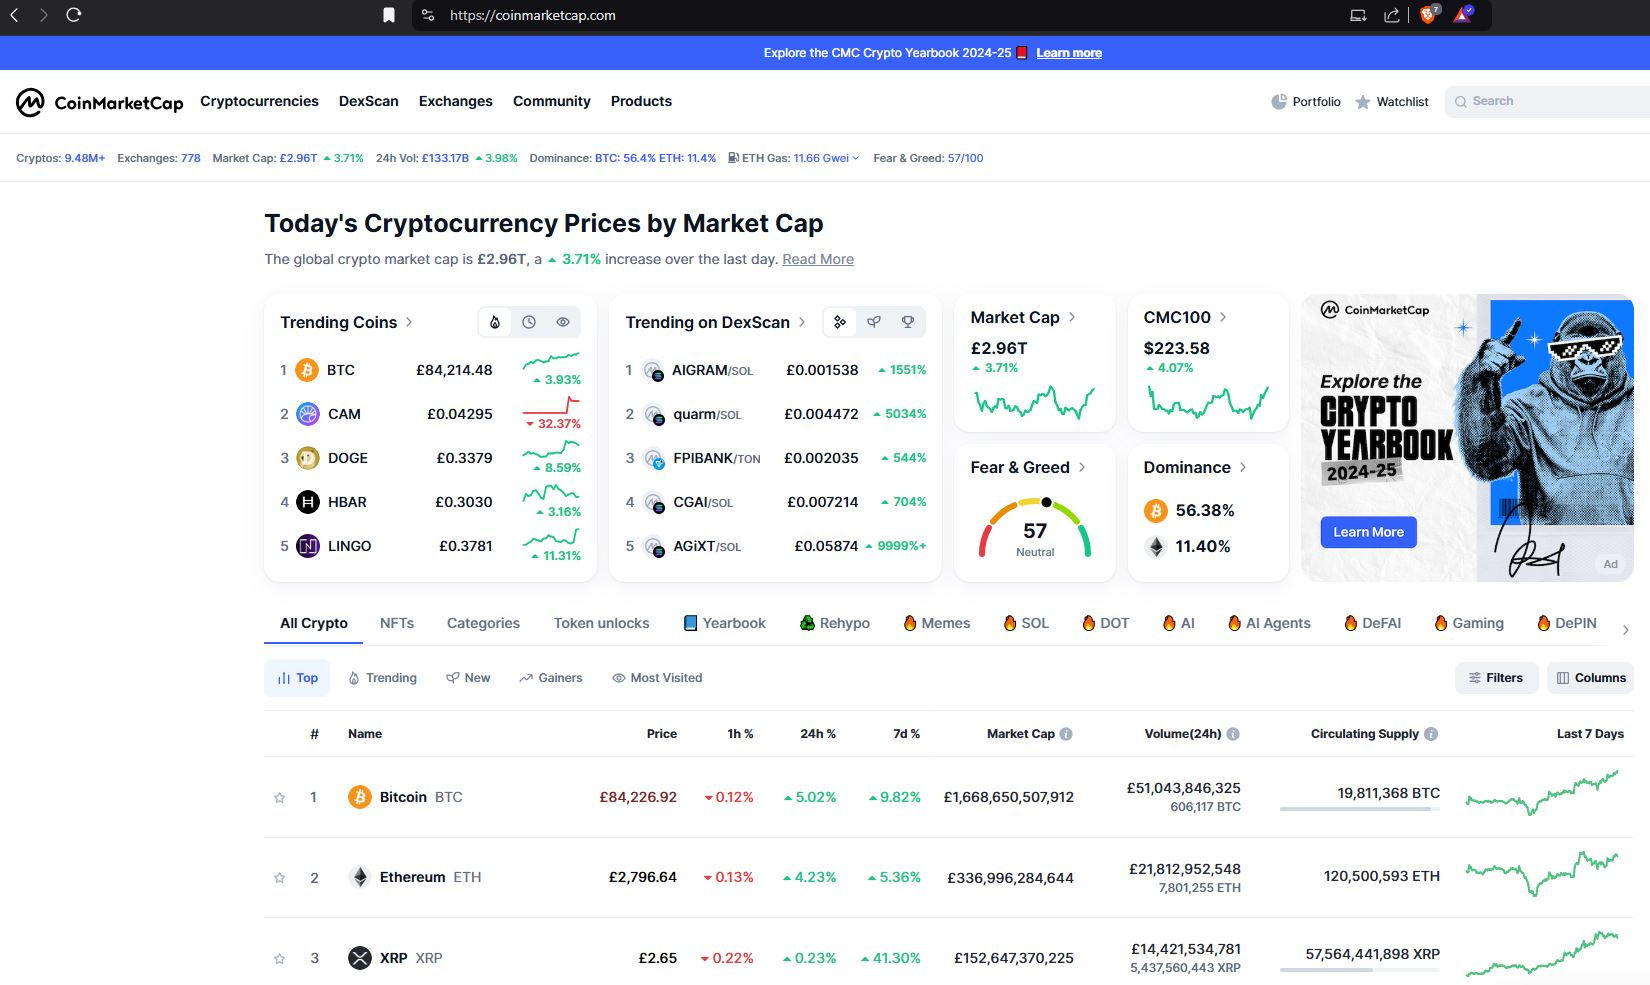

- Bitcoin £84,227
- Ethereum £2,797
- XRP - £3

Just over £87k. Let's check our calculation.

In [9]:
if __name__ == "__main__":

    # Arbitrary user selected portfolio - amend as required
    bitcoin_gbp = Coin("bitcoin", "GBP")
    ethereum_gbp  = Coin("ethereum", "GBP")
    xrp_gbp = Coin("xrp", "GBP")
    
    portfolio = Portfolio([Position(bitcoin_gbp, 1), Position(ethereum_gbp, 1), Position(xrp_gbp,1)])  
    portfolio_value = portfolio.get_total_value()
          
    print(f"The total value of your portfolio on {now:%A}, {now:%d-%m-%Y} is {Coin.target_currency} {portfolio_value:,.2f}.")

The total value of your portfolio on Friday, 17-01-2025 is GBP 87,028.47.


Excellent, that's in line. So, that's us done in terms of scraping the data, and creating custom classes to store our data. The final step is to present the data in a more aesthetic way.

### Section 5. Tabular Display